In [2]:
import nibabel as nib
import numpy as np
from pathlib import Path
import re
from preprocessing import normalize_image, zscore_image
import os, pathlib
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt


In [7]:
def load_volume_from_slices(slice_dir):
    """
    Load a 3D MRI volume from a directory of per-slice .nii files.
    Assumes each slice is a (2, H, W) complex image → magnitude is computed.
    
    Args:
        slice_dir (str or Path): Directory containing per-slice .nii files

    Returns:
        np.ndarray: 3D volume of shape (H, W, D)
    """
    slice_dir = Path(slice_dir)
    slice_files = sorted(slice_dir.glob("slice_*.nii"), key=lambda p: int(re.search(r'slice_(\d+)', p.name).group(1)))

    slices = []
    for nii_path in slice_files:
        img = nib.load(str(nii_path))
        data = img.get_fdata()  # shape: (2, H, W) or (H, W)

        if data.shape[0] == 2:  # complex image: compute magnitude
            mag = np.abs(data[0] + 1j * data[1])
        else:  # already magnitude
            mag = data

        slices.append(mag)

    # Stack into 3D volume: (H, W, num_slices)
    volume = np.stack(slices, axis=-1)
    return volume

In [6]:
# load MRI volume
volume = load_volume_from_slices("/ess/scratch/scratch1/rachelgordon/complex_fully_sampled/fastMRI_breast_001_1")
print(volume.shape)

(320, 320, 83)


In [7]:
# intesnity normalize + convert intensities to z-scores
norm_volume = zscore_image(normalize_image(volume))
print(norm_volume.shape)

(320, 320, 83)


In [4]:
import matplotlib.pyplot as plt

def plot_slice_pair(vol_raw, vol_norm, slice_idx=None, cmap="gray"):
    """
    Plot the same slice from two 3D volumes side by side (e.g., unnormalized and normalized).

    Args:
        vol_raw (np.ndarray): Original unnormalized 3D volume, shape (H, W, D)
        vol_norm (np.ndarray): Normalized 3D volume, shape (H, W, D)
        slice_idx (int, optional): Index of the slice to plot. Defaults to center slice.
        cmap (str): Colormap for plotting (default is 'gray')
    """
    assert vol_raw.shape == vol_norm.shape, "Volumes must have the same shape"
    if slice_idx is None:
        slice_idx = vol_raw.shape[-1] // 2

    slice_raw = vol_raw[:, :, slice_idx]
    slice_norm = vol_norm[:, :, slice_idx]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(slice_raw, cmap=cmap)
    axes[0].set_title(f"Unnormalized (slice {slice_idx})")
    axes[0].axis("off")

    axes[1].imshow(slice_norm, cmap=cmap)
    axes[1].set_title(f"Normalized (slice {slice_idx})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


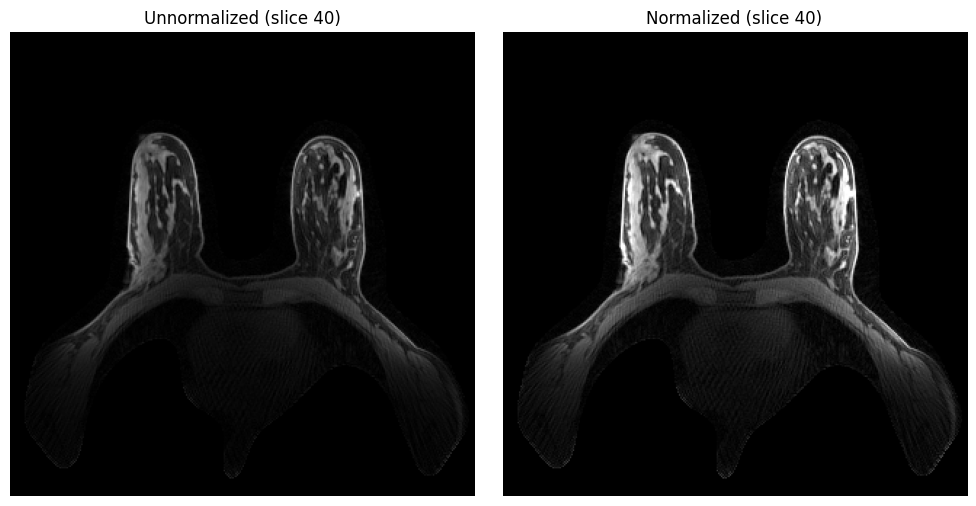

In [9]:
plot_slice_pair(volume, norm_volume, slice_idx=40)

# Plot Predicted Masks

In [8]:
import os, glob, random, pathlib
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# I/O helpers
# ------------------------------------------------------------------
def load_mask_npy(path: pathlib.Path, slice_idx: int) -> np.ndarray:
    """Load a 3D mask volume from .npy and return a 2D slice."""
    data = np.load(path)
    return data[:, :, slice_idx].astype(np.float32)

def load_magnitude_nifti(gt_dir: pathlib.Path, slice_idx: int) -> np.ndarray:
    """
    Load a single slice magnitude image from the ground-truth directory.
    File is expected to be named like: slice_042_frame_000.nii
    """
    slice_file = gt_dir / f"slice_{slice_idx:03d}_frame_000.nii"
    data = nib.load(str(slice_file)).get_fdata()
    real, imag = data[0], data[1]
    return np.sqrt(real**2 + imag**2).astype(np.float32)



def corresponding_gt(mask_path: pathlib.Path) -> pathlib.Path:
    """
    Map a mask .npy path to the corresponding ground truth image directory
    based on patient ID.
    Example:
      /.../3dseg_masks/fastMRI_breast_090_1.npy
    → /.../complex_fully_sampled/fastMRI_breast_090_1/
    """
    patient_id = mask_path.stem  # e.g., "fastMRI_breast_090_1"
    return pathlib.Path(GT_ROOT) / patient_id



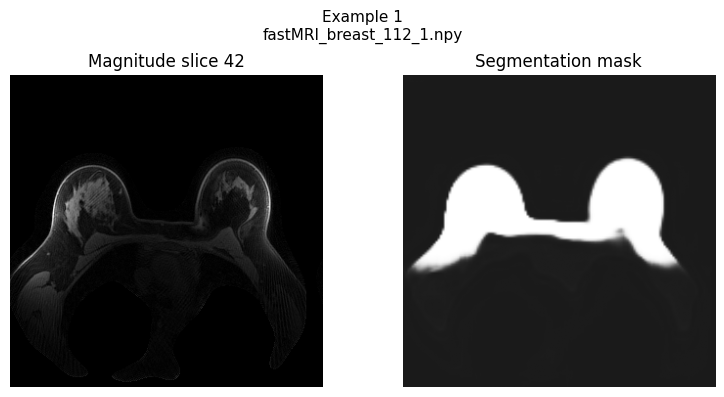

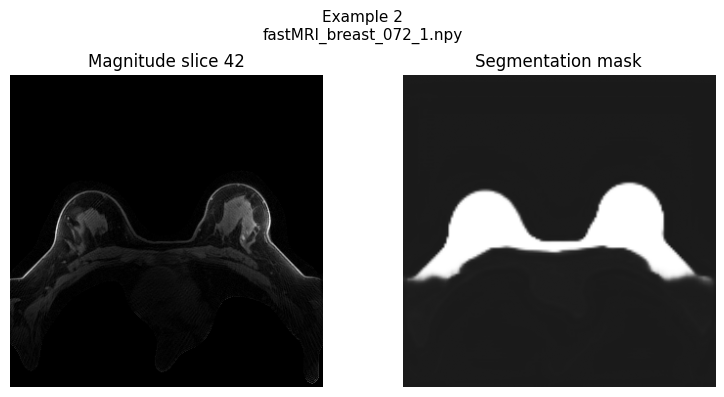

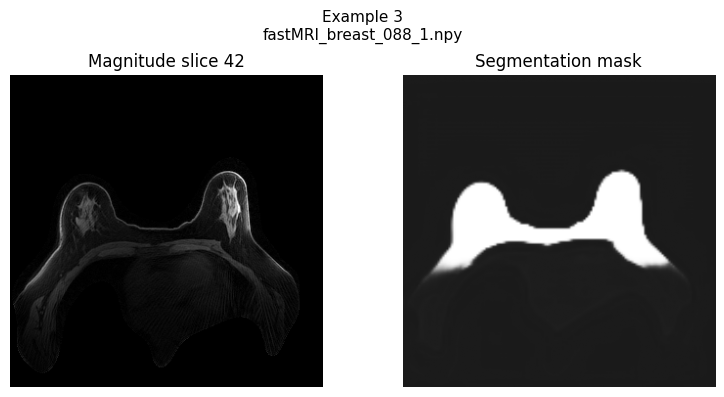

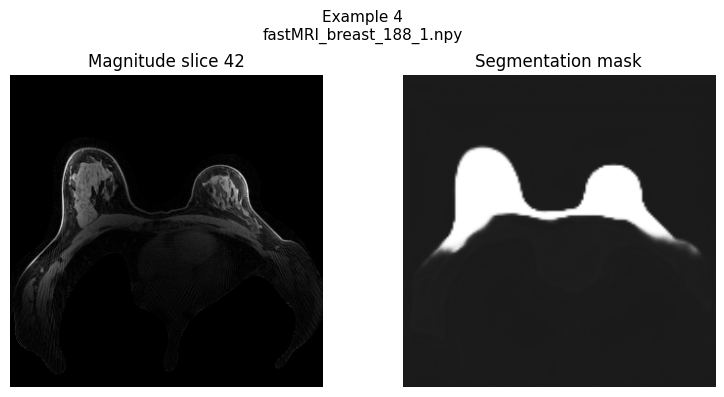

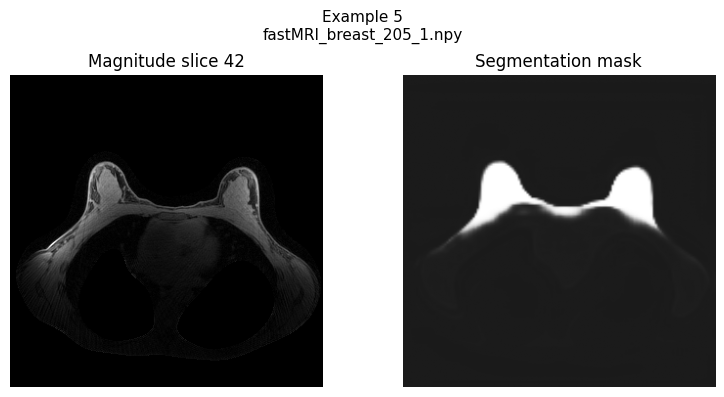

In [11]:
# ------------------------------------------------------------------
# CONFIG – change paths / sample count if you like
# ------------------------------------------------------------------
MASK_ROOT = "/ess/scratch/scratch1/rachelgordon/3dseg_masks"
GT_ROOT   = "/ess/scratch/scratch1/rachelgordon/complex_fully_sampled"
N_EXAMPLES = 5                           # show up to this many pairs


# ------------------------------------------------------------------
# Collect valid pairs
# ------------------------------------------------------------------
mask_files = [pathlib.Path(p) for p in glob.iglob(f"{MASK_ROOT}/**/*.npy", recursive=True)]

pairs = []
for m in mask_files:
    gt = corresponding_gt(m)
    if gt.exists():
        pairs.append((m, gt))

if not pairs:
    raise RuntimeError("No mask / ground‑truth pairs matched!")

random.shuffle(pairs)
pairs = pairs[:min(N_EXAMPLES, len(pairs))]

# ------------------------------------------------------------------
# Plot pairs
# ------------------------------------------------------------------
SLICE_IDX = 42

for idx, (mask_path, gt_dir) in enumerate(pairs[:N_EXAMPLES], 1):
    mask = load_mask_npy(mask_path, slice_idx=SLICE_IDX)
    mag  = load_magnitude_nifti(gt_dir, slice_idx=SLICE_IDX)

    mag_disp = (mag - mag.min()) / (np.ptp(mag) + 1e-8)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f"Example {idx}\n{mask_path.relative_to(MASK_ROOT)}", fontsize=11)

    ax[0].imshow(mag_disp, cmap="gray")
    ax[0].set_title(f"Magnitude slice {SLICE_IDX}")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray", alpha=0.9)
    ax[1].set_title("Segmentation mask")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Plot FGT + Blood Vessel Segmentation Masks

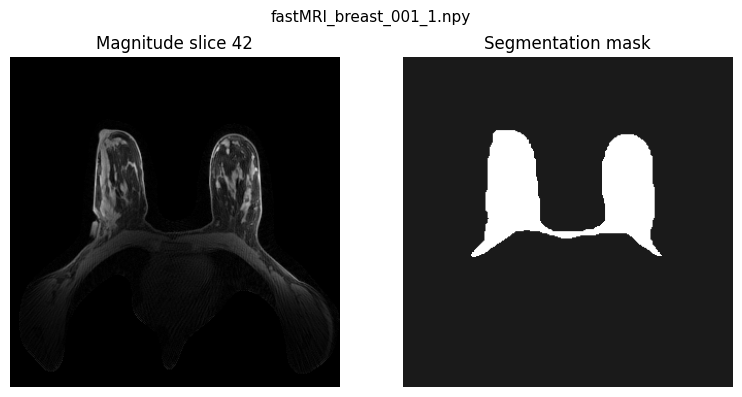

/tmp/ipykernel_30813/2636332599.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


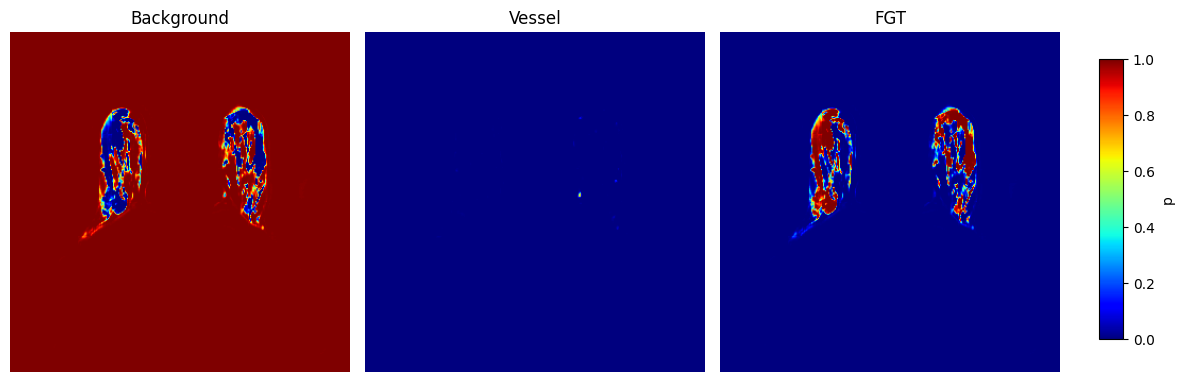

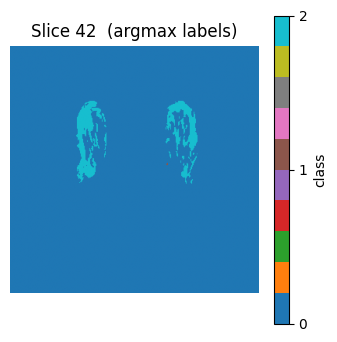

In [9]:
patient_id = '001'
SLICE_IDX = 42



MASK_ROOT = "/ess/scratch/scratch1/rachelgordon/3dseg_masks"
GT_ROOT   = "/ess/scratch/scratch1/rachelgordon/complex_fully_sampled"

mask_path = Path(f"/ess/scratch/scratch1/rachelgordon/3dseg_masks/fastMRI_breast_{patient_id}_1.npy")
gt_dir   = Path(f"/ess/scratch/scratch1/rachelgordon/complex_fully_sampled/fastMRI_breast_{patient_id}_1")

mask = load_mask_npy(mask_path, slice_idx=SLICE_IDX)
mask = mask > 0.5

mag  = load_magnitude_nifti(gt_dir, slice_idx=SLICE_IDX)

mag_disp = (mag - mag.min()) / (np.ptp(mag) + 1e-8)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f"{mask_path.relative_to(MASK_ROOT)}", fontsize=11)

ax[0].imshow(mag_disp, cmap="gray")
ax[0].set_title(f"Magnitude slice {SLICE_IDX}")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray", alpha=0.9)
ax[1].set_title("Segmentation mask")
ax[1].axis("off")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 1. Load the prediction volume
#    Shape: (C=3, H=320, W=320, D=96)
# ------------------------------------------------------------------
pred_path = f"/ess/scratch/scratch1/rachelgordon/3dseg_dv_masks/fastMRI_breast_{patient_id}_1.npy"
pred = np.load(pred_path)                 # float or uint, no squeeze
# print("pred shape:", pred.shape)

# ------------------------------------------------------------------
# 2. Pick one slice along the last axis (D)
# ------------------------------------------------------------------
slice_prob = pred[..., SLICE_IDX]                 # → (3, 320, 320)

# If pred already contains hard labels (0/1) you can skip the softmax test
is_prob = slice_prob.dtype.kind == 'f' and slice_prob.max() <= 1.0
# print("probabilities?" , is_prob)

# ------------------------------------------------------------------
# 3a.  Visualise each class probability plane
# ------------------------------------------------------------------
# plot 
classes = ["Background", "Vessel", "FGT"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, img, cls in zip(axes, slice_prob, classes):
    im = ax.imshow(img, cmap='jet', vmin=0, vmax=1)
    ax.set_title(cls)
    ax.axis('off')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])    # [left, bottom, width, height]
fig.colorbar(axes[0].images[0], cax=cax, label='p')
# fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label='p')
plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.show()

# ------------------------------------------------------------------
# 3b.  Convert to a single hard-label map and show it
# ------------------------------------------------------------------
labels = slice_prob.argmax(axis=0)        # (320, 320)  integer {0,1,2}

plt.figure(figsize=(4, 4))
plt.imshow(labels, cmap='tab10', vmin=0, vmax=2)
plt.title(f'Slice {SLICE_IDX}  (argmax labels)')
plt.axis('off')
plt.colorbar(ticks=[0,1,2], label='class')
plt.show()

